In [37]:
#imports and defs
import pythia8
from pyjet import cluster, DTYPE_PTEPM
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
plt.style.use("dark_paper")

def show(vec):
    string = (4*"{:.2e} ").format(vec.e(),vec.px(),vec.py(),vec.pz())
    print(string)
def to_array(vec):
    return np.array([vec.e(),vec.px(),vec.py(),vec.pz()])
def prtStable(pid):
    if abs(pid) == 211: return True #pion
    if abs(pid) == 321: return True #K+-
    if abs(pid) == 11: return True #electron
    if abs(pid) == 13: return True #muon?
    if abs(pid) == 2212: return True #proton
    #
    #if abs(pid) == 22: return True #gamma
    #if abs(pid) == 130: return True #K_l
    return False
def heavyFlavor(pid):
    if abs(pid) == 411: return True
    if abs(pid) == 421: return True
    if abs(pid) == 431: return True
    if abs(pid) == 4122: return True
    if abs(pid) == 511: return True
    if abs(pid) == 521: return True
    if abs(pid) == 531: return True
    if abs(pid) == 5122: return True
    return False
def getData(prt):
    data = [prt.index(),prt.name(),prt.id(),prt.status(),prt.mother1(),prt.mother2(),
            prt.daughter1(),prt.daughter2(),prt.e(),prt.px(),prt.py(),prt.pz(),prt.m(),prt.pT(),prt.eta(),prt.phi(),prt.theta()]
    keys = ["N","NAME","ID","STATUS","M1","M2","D1","D2","E", "px", "py", "pz" , "mass","pT","eta","phi","theta"]
    return {key:value for key,value in zip(keys,data)}
def getDataLight(prt):
    data = [prt.index(),prt.name(),prt.id(),prt.status(),
            prt.e(),prt.px(),prt.py(),prt.pz(),prt.m(),prt.pT(),prt.eta(),prt.phi(),prt.theta()]
    keys = ["N","NAME","ID","STATUS","E", "px", "py", "pz" , "mass","pT","eta","phi","theta"]
    return {key:value for key,value in zip(keys,data)}
def getInfo(prt):
    string = "{:^2d} {:^11s} {:^5d} {:^6d} {:<3d} {:>3d}  {:<3d} {:>3d}    ".format(prt.index(),prt.name(),prt.id(),
                                                                       prt.status(),
                                                                       prt.mother1(),prt.mother2(),
                                                                       prt.daughter1(),prt.daughter2())
    string += (5*" {:>8.3f} ").format(prt.e(),prt.px(),prt.py(),prt.pz(),prt.m())
    return string

In [2]:
# Setup Pythia Parameters
# Generator. Shorthand for event.
pythia = pythia8.Pythia()

# Set up incoming beams, for frame with unequal beam energies.
pythia.readString("Beams:frameType = 2")
# BeamA = proton.
pythia.readString("Beams:idA = 2212")
pythia.settings.parm("Beams:eA", 100.)
# BeamB = electron.
pythia.readString("Beams:idB = 11")#11
pythia.settings.parm("Beams:eB", 10.) # used a 100 was good before
# Phase-space cut: minimal Q2 of _process.
pythia.settings.parm("PhaseSpace:Q2Min", 10.)
# Set up DIS _process within some phase space.
# Neutral current (with gamma/Z interference).
pythia.readString("WeakBosonExchange:ff2ff(t:gmZ) = on")
# Uncomment to allow charged current.
pythia.readString("WeakBosonExchange:ff2ff(t:W) = on")
# Set dipole recoil on. Necessary for DIS + shower.
pythia.readString("SpaceShower:dipoleRecoil = on")
# Allow emissions up to the kinematical limit,
# since rate known to match well to matrix elements everywhere.
pythia.readString("SpaceShower:pTmaxMatch = 2")
# QED radiation off lepton not handled yet by the new procedure.
pythia.readString("PDF:lepton = off")
pythia.readString("TimeShower:QEDshowerByL = off")
# Setting the random seed
pythia.readString("Random:setSeed = on")
pythia.readString("Random:seed = 0")
# Removing FSR and ISR
pythia.readString("PartonLevel:FSR = off")
pythia.readString("PartonLevel:ISR = off")
# # QCD pp
# pythia.readString("HardQCD:all = on");
# pythia.readString("PhaseSpace:pTHatMin = .2");
# Initialize.
print("Pythia generator initialized successfully: ", pythia.init())

Pythia generator initialized successfully:  True


In [5]:
def selection(prt):
    sel = prt.isFinal() and prt.vProd().pAbs()<1000 and abs(prt.id())<=5 #and prtStable(prt.id()) # and prt.isCharged()
    return sel

In [39]:
# keys
#keys = ['EVENT', "N","NAME","ID","STATUS","M1","M2","D1","D2","E", "px", "py", "pz" , "mass", "pT" ,"eta","phi","theta"]
cols_to_save = ["EVENT", "NAME","ID","STATUS","E", "px", "py", "pz" , "mass","pT","eta","phi","theta"]
convert_dict = {'NAME': 'category', 
                'ID': 'category',
                'mass': 'category',
                'STATUS' : 'int8',
                'EVENT': 'int16',
               } 
for key in ["E", "px", "py", "pz" ,"pT","eta","phi","theta"]:
    convert_dict[key] = 'float32'

In [13]:
#%%capture out
nEvents = 10000
q_vec = list()
scalars = list()
targets = list()
df0 = pd.DataFrame(columns=keys)
df0 = df0.astype(convert_dict)
df1 = pd.DataFrame(columns=keys)
df1 = df0.astype(convert_dict)

for iEvent in tqdm(range(0,nEvents)):
    if not pythia.next(): continue
    event = pythia.event
    ki  = event[2].p() #in e
    kf = event[6].p() # out e
    P  = event[1].p() # in p 
    q  = ki - kf
    Q2 = -q.m2Calc() # Q^2
    xB = Q2/(2*(P*q)) #Bjorken X
    y  = P*q/(P*ki)
    s  = (ki+P).mCalc()  
    mat = pythia8.RotBstMatrix()
    mat.toCMframe(q, P*xB*2)
    vec = P*xB+q
    vec.rotbst(mat)
    scalars.append([Q2,xB,y,s])
    targets.append(to_array(vec)) #breit target
    q_vec.append(to_array(q)) #lab q #lab P is know (100,0,0, ~99.997)
    #print("=="*20 + f" Event {iEvent:^3d}/{nEvents:^3d} " + "=="*20, end="\r")
    #print(("{:^2s} {:^11s} {:^5s} {:^6s} {:^8s} {:^8s}   " + 5*"{:^10s}").format("N","NAME","ID","STATUS","PARENTS","CHILDREN","E", "px", "py", "pz" , "m")) 
    for prt in event:
        #print(getInfo(prt))
        if selection(prt) or prt.index()in[1,2,5]:
            prt_dict = getData(prt)
            prt_dict['EVENT'] = iEvent
            df0 = df0.append(prt_dict,ignore_index=True)
    #prt = event[5] #get outgoing parton
    #get outgoing parton daughters
#     df.fs_daughters = np.unique([daughterid for daughterid in prt.daughterListRecursive()\
#                     if selection(event[daughterid])]) 
    #print("=="*24 + "=="*24)
    for prt in event:
        prt.rotbst(mat)
        #print(getInfo(prt))
        if selection(prt) or prt.index()in[1,2,5]:
            prt_dict = getData(prt)
            prt_dict['EVENT'] = iEvent
            df1 = df1.append(prt_dict,ignore_index=True)
df0.loc[:,cols_to_save].to_hdf("data/EIC/lab1.h5", key=f"data",complib='zlib', complevel=9, format='fixed')
df1.loc[:,cols_to_save].to_hdf("data/EIC/breit_cat1.h5", key=f"data",complib='zlib', complevel=9, format='fixed')
pd.DataFrame(targets,columns=['E','px', 'py','pz']).to_hdf("data/EIC/targets_breit1.h5",key='data')
pd.DataFrame(q_vec,columns=['E','px', 'py','pz']).to_hdf("data/EIC/q_lab1.h5",key='data')
pd.DataFrame(scalars, columns=['Q2', 'xB', 'y', 's']).to_hdf("data/EIC/scalars1.h5",key='data')

100%|██████████| 10000/10000 [23:53<00:00,  6.98it/s]
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/pandas/core/generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['NAME', 'ID'], dtype='object')]

  encoding=encoding,


In [8]:
#%%capture out
nEvents = 10000
q_vec = list()
scalars = list()
targets = list()
df0 = pd.DataFrame(columns=keys)
df0 = df0.astype(convert_dict)
df1 = pd.DataFrame(columns=keys)
df1 = df0.astype(convert_dict)

for iEvent in tqdm(range(0,nEvents)):
    if not pythia.next(): continue
    event = pythia.event
    ki  = event[2].p() #in e
    kf = event[6].p() # out e
    P  = event[1].p() # in p 
    q  = ki - kf
    Q2 = -q.m2Calc() # Q^2
    xB = Q2/(2*(P*q)) #Bjorken X
    y  = P*q/(P*ki)
    s  = (ki+P).mCalc()  
    mat = pythia8.RotBstMatrix()
    mat.toCMframe(q, P*xB*2)
    vec = P*xB+q
    vec.rotbst(mat)
    scalars.append([Q2,xB,y,s])
    targets.append(to_array(vec)) #breit target
    q_vec.append(to_array(q)) #lab q #lab P is know (100,0,0, ~99.997)
    #print("=="*20 + f" Event {iEvent:^3d}/{nEvents:^3d} " + "=="*20, end="\r")
    #print(("{:^2s} {:^11s} {:^5s} {:^6s} {:^8s} {:^8s}   " + 5*"{:^10s}").format("N","NAME","ID","STATUS","PARENTS","CHILDREN","E", "px", "py", "pz" , "m")) 
    for prt in event:
        #print(getInfo(prt))
        if selection(prt) or prt.index()in[1,2,5]:
            prt_dict = getData(prt)
            prt_dict['EVENT'] = iEvent
            df0 = df0.append(prt_dict,ignore_index=True)
    #prt = event[5] #get outgoing parton
    #get outgoing parton daughters
#     df.fs_daughters = np.unique([daughterid for daughterid in prt.daughterListRecursive()\
#                     if selection(event[daughterid])]) 
    #print("=="*24 + "=="*24)
    for prt in event:
        prt.rotbst(mat)
        #print(getInfo(prt))
        if selection(prt) or prt.index()in[1,2,5]:
            prt_dict = getData(prt)
            prt_dict['EVENT'] = iEvent
            df1 = df1.append(prt_dict,ignore_index=True)
df0.loc[:,cols_to_save].to_hdf("data/EIC/lab1.h5", key=f"data",complib='zlib', complevel=9, format='fixed')
df1.loc[:,cols_to_save].to_hdf("data/EIC/breit_cat1.h5", key=f"data",complib='zlib', complevel=9, format='fixed')
pd.DataFrame(targets,columns=['E','px', 'py','pz']).to_hdf("data/EIC/targets_breit1.h5",key='data')
pd.DataFrame(q_vec,columns=['E','px', 'py','pz']).to_hdf("data/EIC/q_lab1.h5",key='data')
pd.DataFrame(scalars, columns=['Q2', 'xB', 'y', 's']).to_hdf("data/EIC/scalars1.h5",key='data')

100%|██████████| 10000/10000 [20:46<00:00,  8.02it/s]


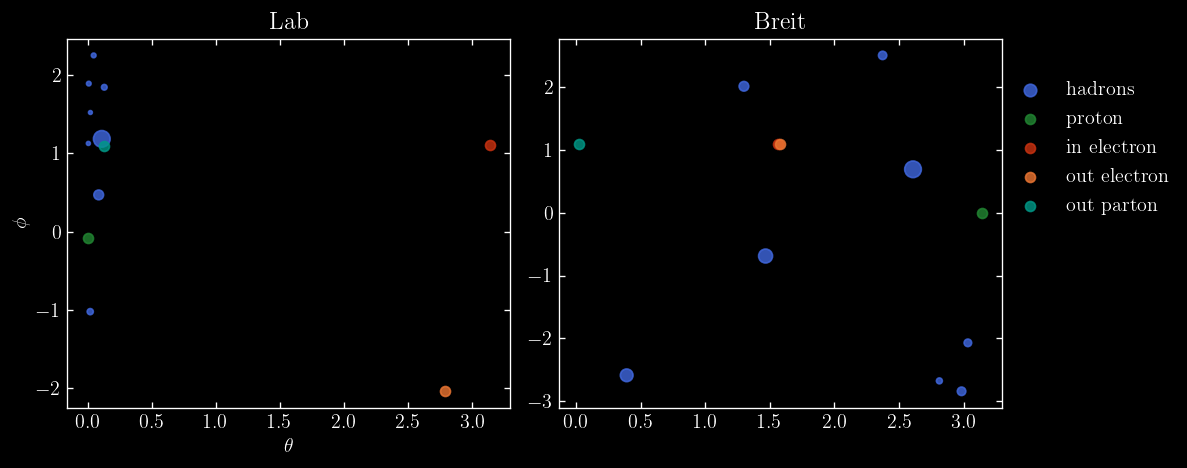

In [530]:
i = 2
for ii in range(1):
    df = events[i]
    df2 = events_breit[i]
    A = 100/df.pT.values[4:].max()
    fig, (ax,ax1) = plt.subplots(1, 2, dpi=120,sharey=False,figsize=(10,4))
    ax.scatter(df.theta[4:], df.phi[4:], s = A*df.pT.values[4:], 
               alpha=.8, label="hadrons")
    ax.scatter(df.theta.values[0], df.phi.values[0],# s = A*df.pT.values[0], 
               alpha=.8, label="proton")
    ax.scatter(df.theta.values[1], df.phi.values[1],# s = A*df.pT.values[1], 
               alpha=.8, label="in electron")
    ax.scatter(df.theta.values[3], df.phi.values[3],# s = A*df.pT.values[3], 
               alpha=.8, label="out electron")
    ax.scatter(df.theta.values[2], df.phi.values[2],# s = A*df.pT.values[2], 
               alpha=.8, label="out parton")
    ax.set_title("Lab")

    A = 100/df2.pT.values[4:].max()
    ax1.scatter(df2.theta[4:], df2.phi[4:], s = A*df2.pT.values[4:], 
                alpha=.8, label="hadrons")
    ax1.scatter(df2.theta.values[0], df2.phi.values[0], #s = A*df2.pT.values[0],
                alpha=.8, label="proton")
    ax1.scatter(df2.theta.values[1], df2.phi.values[1], #s = A*df2.pT.values[1],
                alpha=.8, label="in electron")
    ax1.scatter(df2.theta.values[3], df2.phi.values[3], #s = A*df2.pT.values[3],
                alpha=.8, label="out electron")
    ax1.scatter(df2.theta.values[2], df2.phi.values[2], #s = A*df2.pT.values[2],
                alpha=.8, label="out parton")
    ax1.set_title("Breit")

    plt.legend(loc=(1, .5))
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel(r"$\phi$")
    fig.tight_layout()
    plt.show()

In [43]:
Rs = np.linspace(np.pi/4,3*np.pi/4,100)
losses = []
for R in Rs:
    loss = 0
    for i in range(len(events_breit)):
        df = events_breit[i][4:]
        psi = (np.pi - df.theta.values)
        Jet_region = df[R < psi.round(10)]
        pred = Jet_region.loc[:,['E','px','py','pz']].sum().values
        target = targets[i]
        loss += np.mean((pred-target)**2)
    loss /= len(events_breit)
    losses.append(loss)

In [48]:
events_breit[0]

,N,NAME,ID,STATUS,M1,M2,D1,D2,E,px,py,pz,mass,pT,eta,phi,theta
0,1,p+,2212,-12,0,0,15,0,44.727408,8.881784e-16,-5.684342e-14,-44.717566,0.938270,5.685036e-14,-34.991867,-1.555173,3.141593
1,2,e-,11,-12,0,0,8,0,42.904910,-1.407213e+00,-4.284362e+01,1.809816,0.000511,4.286672e+01,0.042207,-1.603630,1.528602
2,5,dbar,-1,-23,3,4,9,9,1.829750,-2.971096e-04,-9.045715e-03,1.799723,0.330000,9.050593e-03,5.985711,-1.603630,0.005029
3,10,e-,11,44,6,6,0,0,42.904910,-1.407213e+00,-4.284362e+01,-1.809816,0.000511,4.286672e+01,-0.042207,-1.603630,1.612991
4,19,n0,2112,63,1,0,0,0,10.836322,5.250297e-01,7.065758e-01,-10.759563,0.939570,8.802872e-01,-3.198118,0.931750,3.059960
5,25,pi+,211,83,21,24,0,0,15.864451,3.919938e-01,-1.381090e-01,-15.858392,0.139570,4.156118e-01,-4.335021,-0.338744,3.115391
6,30,pi-,-211,84,21,24,0,0,0.219867,3.677434e-02,-4.450150e-02,-0.159777,0.139570,5.772985e-02,-1.742300,-0.880187,2.794874
7,33,pi+,211,84,21,24,0,0,1.130725,-3.142287e-01,-1.021434e+00,-0.342042,0.139570,1.068676e+00,-0.314835,-1.869243,1.880555
8,37,K_L0,130,91,28,28,0,0,0.676332,1.925011e-01,8.140901e-02,-0.407585,0.497610,2.090074e-01,-1.421093,0.400092,2.667762
9,38,K_L0,130,91,35,35,0,0,3.236393,-1.495991e-01,-4.098514e-01,-3.168006,0.497610,4.363004e-01,-2.680382,-1.920778,3.004733


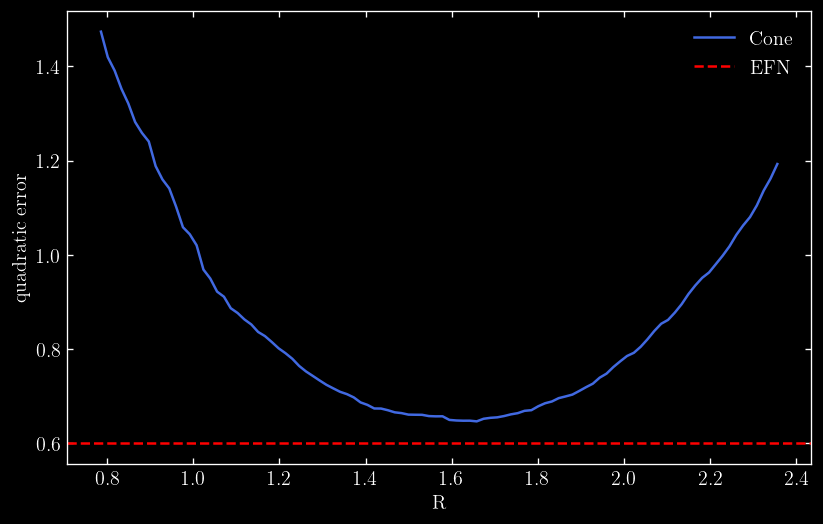

In [44]:
fig, ax = plt.subplots(1,1,figsize=(8,5),dpi=120)
plt.plot(Rs,losses, label= "Cone")
plt.axhline(.6,ls="--",c='red',label="EFN")
plt.legend()
#plt.yscale("log")
plt.ylabel("quadratic error")
plt.xlabel("R")
plt.show()

In [46]:
Rs[np.argmin(losses)]*180/np.pi

95.0

# NN optimization

In [ ]:
# imports
from typing import Optional, Callable, Union
from torch_geometric.typing import OptTensor, PairOptTensor, PairTensor, Adj
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops
from torch import Tensor

import torch
import torch_geometric
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import dense_to_sparse
from torch_geometric.utils import to_networkx
from torch_geometric.nn import global_mean_pool
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

%load_ext autoreload
%aimport flow
%autoreload 1

In [801]:
def _process(df,target,scalars):
    x = df.loc[4:,["px","py","pz"]].values/df.loc[4:,"E"].values.reshape(-1,1)
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(to_array(target)).float().view(1,4)
#     distances = getDR(x)
#     edge_index=torch_geometric.nn.radius_graph(distances,r=1)#GCNConv adds self loops
#     edge_index=dense_to_sparse(torch.ones(x.shape[0],x.shape[0]).fill_diagonal_(0))[0]#complete
    edge_index=dense_to_sparse(torch.eye(x.shape[0]))[0]#self only
#     edge_index=dense_to_sparse(torch.ones(x.shape[0],x.shape[0]))[0]#complete graph
#    edge_index=None
    data = Data(x=x, y=y, edge_index=edge_index) 
    data.p = torch.from_numpy(df.loc[4:,["E","px","py","pz"]].values).float()
    data.scalars = torch.Tensor(scalars).float().view(1,4)
    return data

In [802]:
train_set = [_process(x,y,z) for x,y,z in zip(events_breit[:200],targets,scalars)]
train_loader = DataLoader(train_set, batch_size=1,shuffle=False)

In [803]:
val_set = [_process(x,y,z) for x,y,z in zip(events_breit[200:300],targets[200:300],scalars[200:300])]
val_loader = DataLoader(val_set, batch_size=1,shuffle=False)

In [804]:
# Gather some statistics about the first graph.
data = train_set[1]  # Get the first graph object.
print(data)
print('=============================================================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 21], p=[21, 4], scalars=[1, 4], x=[21, 3], y=[1, 4])
Number of nodes: 21
Number of edges: 21
Average node degree: 1.00
Contains isolated nodes: True
Contains self-loops: True
Is undirected: True


In [882]:
def val_step(nn, batch, criterion):
    nn.eval()
    with torch.no_grad():
#         pred = nn(batch.x, batch.scalars, batch.p, batch.edge_index, batch.batch)
        weights = nn(batch.x, batch.scalars, batch.p, batch.edge_index, batch.batch)
        pred = (weights * batch.p).sum(axis=-2,keepdim=True)
        loss = criterion(pred, batch.y).mean()
    return loss.item()

def train_step(nn, batch, criterion, optim,step=0):
    nn.train()
#     pred = nn(batch.x, batch.scalars, batch.p, batch.edge_index, batch.batch)
    weights = nn(batch.x, batch.scalars, batch.p, batch.edge_index, batch.batch)
    pred = (weights * batch.p).sum(axis=-2,keepdim=True)
    loss = criterion(pred, batch.y)
    loss = loss.mean() #mean over batch
    loss.backward()
    optim.step()
    optim.zero_grad()
    return loss.item()

def train(nn, data,epochs=100,val=None,verbosity=.1,criterion=None, optim=None):
    criterion= criterion if criterion is not None else torch.nn.MSELoss()
    optim = optim if optim is not None else torch.optim.Adam(nn.parameters(),weight_decay=5e-4,lr=1e-5) #5e-4, 1e-4
    if val is not None: val_losses = []
    train_losses = []
    step = -1
    for epoch in range(1,epochs):
        loss_train = 0
        for batch in data:
            batch.to('cuda:0')
            step += 1
            loss_train += train_step(nn, batch,criterion=criterion, optim=optim,step=step)
        loss_train/=len(data)
        train_losses.append(loss_train)
        if epoch%int(np.clip(verbosity*epochs,1,np.inf))==0:
            loss_val = 0
            if val is not None: 
                for batch in val:
                    batch.to('cuda:0')
                    loss_val += val_step(nn,batch,criterion)
                loss_val/= len(val)
                val_losses.append(loss_val)
                print(f"Epoch {epoch:^3d}/{epochs} | train {loss_train:^4.4f}| val {loss_val:^4.4f}")
            else:
                print(f"Epoch {epoch:^3d}/{epochs} | train {loss_train:^4.4f}")#| Loss class {loss[1]:^4.4f}")
    losses = (train_losses, val_losses) if val is not None else train_losses
    return losses

In [903]:
from flow import EFN
torch.manual_seed(12345)
hidden_channels = 128
nn = torch.nn.Sequential(torch.nn.Linear(3+4,hidden_channels),
                                       torch.nn.ReLU(),
                                       torch.nn.BatchNorm1d(hidden_channels),
                                       torch.nn.Linear(hidden_channels,hidden_channels),
                                       torch.nn.ReLU(),
                                       torch.nn.Linear(hidden_channels,hidden_channels),
                                       torch.nn.ReLU(),                                       
                                       torch.nn.Linear(hidden_channels,hidden_channels),
                                       torch.nn.ReLU(),
                                       torch.nn.Linear(hidden_channels,1),
                                       torch.nn.Sigmoid()
                                      )
efn_new = EFN(nn)
efn_new.to("cuda:0")
losses = train(efn_new, train_loader,epochs=100,val=val_loader,verbosity=.05)

Epoch  5 /100 | train 1412.5596| val 11.5931
Epoch 10 /100 | train 444.9636| val 3.1626
Epoch 15 /100 | train 69.0380| val 3.1627
Epoch 20 /100 | train 18.9789| val 3.1627
Epoch 25 /100 | train 8.0018| val 3.1627


KeyboardInterrupt: 

In [870]:
batch = next(iter(train_loader))
batch.to("cuda:0")
efn_bn(batch.x, batch.scalars, batch.p, batch.edge_index, batch.batch)

tensor([[3.2177e-09],
        [6.4132e-08],
        [2.0396e-07],
        [8.6705e-08],
        [6.6948e-08],
        [4.9991e-08],
        [1.3009e-02],
        [1.9326e-07],
        [6.0971e-08],
        [2.0800e-02],
        [5.1255e-08],
        [3.7365e-08],
        [9.9848e-01],
        [9.9115e-01],
        [1.2743e-07],
        [4.3081e-08],
        [5.9584e-08],
        [5.3443e-08],
        [1.3436e-08],
        [9.9997e-01],
        [8.0136e-08],
        [9.9891e-01],
        [4.4485e-09],
        [1.9694e-08],
        [2.8785e-06],
        [9.9931e-01],
        [7.5247e-01],
        [9.9999e-01]], device='cuda:0', grad_fn=<ScatterAddBackward>)

In [867]:
efn_bn = EFN()
efn_bn.to("cuda:0")
losses = train(efn_bn, train_loader,epochs=1000,val=val_loader,verbosity=.05)

Epoch 50 /1000 | train 1.2432| val 3.1600
Epoch 100/1000 | train 0.6512| val 2.6331
Epoch 150/1000 | train 0.6172| val 2.4294
Epoch 200/1000 | train 0.5982| val 2.3890
Epoch 250/1000 | train 0.5811| val 2.3554
Epoch 300/1000 | train 0.5652| val 2.3695
Epoch 350/1000 | train 0.5557| val 2.4152
Epoch 400/1000 | train 0.5516| val 2.4205
Epoch 450/1000 | train 0.5483| val 2.4268
Epoch 500/1000 | train 0.5456| val 2.4280
Epoch 550/1000 | train 0.5446| val 2.4602
Epoch 600/1000 | train 0.5431| val 2.4728
Epoch 650/1000 | train 0.5400| val 2.4417
Epoch 700/1000 | train 0.5380| val 2.4562
Epoch 750/1000 | train 0.5367| val 2.4230
Epoch 800/1000 | train 0.5364| val 2.4129
Epoch 850/1000 | train 0.5355| val 2.4443
Epoch 900/1000 | train 0.5344| val 2.4027
Epoch 950/1000 | train 0.5327| val 2.8489


In [875]:
efn_bn.to("cuda:0")
losses = train(efn_bn, train_loader,epochs=100,val=val_loader,criterion=torch.nn.SmoothL1Loss(beta=.1),verbosity=.05)

Epoch  5 /100 | train 0.4894| val 4.9682
Epoch 10 /100 | train 0.4887| val 4.9774
Epoch 15 /100 | train 0.4893| val 5.0328
Epoch 20 /100 | train 0.4879| val 5.3281
Epoch 25 /100 | train 0.4885| val 5.3869
Epoch 30 /100 | train 0.4882| val 5.3795
Epoch 35 /100 | train 0.4881| val 5.5713
Epoch 40 /100 | train 0.4899| val 5.7015
Epoch 45 /100 | train 0.4909| val 5.5889
Epoch 50 /100 | train 0.4868| val 5.9062
Epoch 55 /100 | train 0.4886| val 5.5321
Epoch 60 /100 | train 0.4877| val 5.5089
Epoch 65 /100 | train 0.4903| val 5.3814
Epoch 70 /100 | train 0.4862| val 5.4104
Epoch 75 /100 | train 0.4867| val 5.4993
Epoch 80 /100 | train 0.4866| val 5.4726
Epoch 85 /100 | train 0.4866| val 5.6045
Epoch 90 /100 | train 0.4867| val 5.7387
Epoch 95 /100 | train 0.4860| val 5.5231


In [876]:
efn_bn.to("cuda:0")
losses = train(efn_bn, train_loader,epochs=100,val=val_loader,criterion=torch.nn.SmoothL1Loss(beta=1),verbosity=.05)

Epoch  5 /100 | train 0.2402| val 5.0112
Epoch 10 /100 | train 0.2393| val 4.9794
Epoch 15 /100 | train 0.2388| val 4.9560
Epoch 20 /100 | train 0.2385| val 4.9946
Epoch 25 /100 | train 0.2383| val 5.0680
Epoch 30 /100 | train 0.2394| val 5.0820
Epoch 35 /100 | train 0.2380| val 5.0961
Epoch 40 /100 | train 0.2381| val 5.1029
Epoch 45 /100 | train 0.2403| val 5.1371
Epoch 50 /100 | train 0.2377| val 5.2965
Epoch 55 /100 | train 0.2397| val 5.4197
Epoch 60 /100 | train 0.2375| val 6.0233
Epoch 65 /100 | train 0.2373| val 6.2707
Epoch 70 /100 | train 0.2377| val 6.1437
Epoch 75 /100 | train 0.2377| val 6.3299
Epoch 80 /100 | train 0.2374| val 6.3709
Epoch 85 /100 | train 0.2392| val 6.3072
Epoch 90 /100 | train 0.2372| val 6.6603
Epoch 95 /100 | train 0.2373| val 6.6760


In [881]:
efn_bn.to("cuda:0")
losses = train(efn_bn, train_loader,epochs=100,val=val_loader,criterion=torch.nn.SmoothL1Loss(beta=.5),verbosity=.05)

Epoch  5 /100 | train 0.3556| val 8.6493
Epoch 10 /100 | train 0.3543| val 8.6643
Epoch 15 /100 | train 0.3542| val 8.7531
Epoch 20 /100 | train 0.3530| val 8.8314
Epoch 25 /100 | train 0.3523| val 9.0330
Epoch 30 /100 | train 0.3518| val 9.2262
Epoch 35 /100 | train 0.3513| val 9.2650
Epoch 40 /100 | train 0.3509| val 9.3435
Epoch 45 /100 | train 0.3506| val 9.3503
Epoch 50 /100 | train 0.3503| val 9.4069
Epoch 55 /100 | train 0.3499| val 9.4354
Epoch 60 /100 | train 0.3494| val 9.4889
Epoch 65 /100 | train 0.3497| val 9.4784
Epoch 70 /100 | train 0.3492| val 9.5030
Epoch 75 /100 | train 0.3486| val 9.5282
Epoch 80 /100 | train 0.3490| val 9.5489
Epoch 85 /100 | train 0.3481| val 9.5609
Epoch 90 /100 | train 0.3485| val 9.5621
Epoch 95 /100 | train 0.3493| val 9.5660


In [ ]:
efn_.to("cuda:0")
losses = train(efn_bn, train_loader,epochs=100,val=val_loader,criterion=torch.nn.SmoothL1Loss(beta=.5),verbosity=.05)

In [767]:
efn = EFN() #5e-4, 1e-4 128 width 3 total layersx
efn.to("cuda:0")
losses = train(efn, train_loader,epochs=1000,val=val_loader,verbosity=.05)

Epoch 50 /1000 | Loss 3.2776|  val 3.1292
Epoch 100/1000 | Loss 0.6227|  val 0.6205
Epoch 150/1000 | Loss 0.5978|  val 0.6168
Epoch 200/1000 | Loss 0.5954|  val 0.6131
Epoch 250/1000 | Loss 0.5935|  val 0.5963
Epoch 300/1000 | Loss 0.5966|  val 0.5913
Epoch 350/1000 | Loss 0.5942|  val 0.6085
Epoch 400/1000 | Loss 0.5929|  val 0.6090
Epoch 450/1000 | Loss 0.5919|  val 0.6095
Epoch 500/1000 | Loss 0.5911|  val 0.6099
Epoch 550/1000 | Loss 0.5905|  val 0.6089
Epoch 600/1000 | Loss 0.5900|  val 0.6077
Epoch 650/1000 | Loss 0.5896|  val 0.6066
Epoch 700/1000 | Loss 0.5893|  val 0.6057
Epoch 750/1000 | Loss 0.5886|  val 0.6033
Epoch 800/1000 | Loss 0.5879|  val 0.6019
Epoch 850/1000 | Loss 0.5873|  val 0.6001
Epoch 900/1000 | Loss 0.5867|  val 0.5993
Epoch 950/1000 | Loss 0.5861|  val 0.5989
